In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import sys
import gc
sys.path.append('/content/drive/MyDrive/Colab Notebooks/1_Papers/3_Attack_generation')
from utils.utils import setup_logging, get_config_from_yaml, process_config, print_config
from dataset.cityscapes import Cityscapes
from metrics.performance import SegmentationMetric
from utils.helper import val_plot
from patch.create import Patch
#from metrics.performance import SegmentationMetric


from pretrained_models.ICNet.icnet import ICNet
from pretrained_models.BisNetV1.model import BiSeNetV1
from pretrained_models.BisNetV2.model import BiSeNetV2
from pretrained_models.PIDNet.model import PIDNet, get_pred_model
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation
import pickle
from copy import deepcopy
# from trainer.trainer import Trainer
# import torch
from tqdm import tqdm
config = get_config_from_yaml('/content/drive/MyDrive/Colab Notebooks/1_Papers/3_Attack_generation/configs/config.yaml')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Getting patches

In [2]:
pidnet_l_p = pickle.load(open( "/content/drive/MyDrive/Colab Notebooks/1_Papers/3_Attack_generation/Experiments/pidnet_l.p", "rb" ))[0]
icnet_p = pickle.load(open( "/content/drive/MyDrive/Colab Notebooks/1_Papers/3_Attack_generation/Experiments/icnet.p", "rb" ))[0]
bisenetv1_p = pickle.load(open( "/content/drive/MyDrive/Colab Notebooks/1_Papers/3_Attack_generation/Experiments/bisenet_v1.p", "rb" ))[0]
segformer_p = pickle.load(open( "/content/drive/MyDrive/Colab Notebooks/1_Papers/3_Attack_generation/Experiments/segformer.p", "rb" )).detach()
patches = [pidnet_l_p,icnet_p,bisenetv1_p,segformer_p]

# Getting data Validation

In [3]:
cityscape_val = Cityscapes(
          root = config.dataset.root,
          list_path = config.dataset.val,
          num_classes = config.dataset.num_classes,
          multi_scale = False,
          flip = False,
          ignore_label = config.train.ignore_label,
          base_size = config.train.base_size,
          crop_size = (config.train.height,config.train.width),
        )

train_dataloader = torch.utils.data.DataLoader(dataset=cityscape_val,
                                            batch_size=4,
                                            shuffle=True,
                                            num_workers=config.train.num_workers,
                                            pin_memory=config.train.pin_memory,
                                            drop_last=config.train.drop_last)

# Getting 4 models

In [4]:
## ICNet
model = torch.load('/content/drive/MyDrive/Colab Notebooks/1_Papers/3_Attack_generation/pretrained_models/ICNet/Copy of resnet50_2024-12-22 08:52:50 EST-0500_176_0.661.pth.tar',map_location=device)
icnet = ICNet(nclass = 19).to(device)
icnet.load_state_dict(model['model_state_dict'])
icnet.eval()
print('ICNet loaded')

## PIDnet-L
model = torch.load('/content/drive/MyDrive/Colab Notebooks/1_Papers/3_Attack_generation/pretrained_models/PIDNet/PIDNet_L_Cityscapes_test.pt',map_location=device)
pidnet_l = get_pred_model(name = 'pidnet_l', num_classes = 19).to(device)
if 'state_dict' in model:
    model = model['state_dict']
model_dict = pidnet_l.state_dict()
model = {k[6:]: v for k, v in model.items() # k[6:] to start after model. in key names
                    if k[6:] in model_dict.keys()}

pidnet_l.load_state_dict(model)
pidnet_l.eval()
print('PIDNet Model loaded')

## BisNetV1
model = torch.load('/content/drive/MyDrive/Colab Notebooks/1_Papers/3_Attack_generation/pretrained_models/BisNetV1/bisnetv1.pth',map_location=device)
bisenetv1 = BiSeNetV1(19,aux_mode = 'eval').to(device)
bisenetv1.load_state_dict(model, strict=False)
bisenetv1.eval()
print('BisNetV1 loaded')

ICNet loaded


<ipython-input-4-0ef16e6e27e9>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('/content/drive/MyDrive/Colab Notebooks/1_Papers/3_Attack_generation/pretr

PIDNet Model loaded
BisNetV1 loaded


<ipython-input-4-0ef16e6e27e9>:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('/content/drive/MyDrive/Colab Notebooks/1_Papers/3_Attack_generation/pret

Segformer loaded
Segformer loaded


Segformer loaded
Segformer loaded


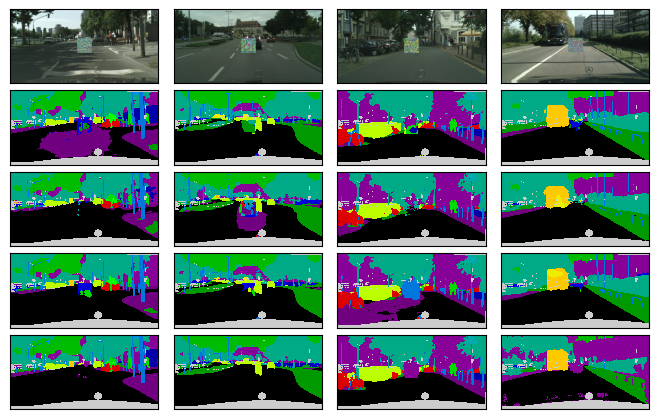

In [21]:
mean_standard = np.array([0.485, 0.456, 0.406],dtype = np.float32)
cstring = 'nipy_spectral'
std_standard = np.array([0.229, 0.224, 0.225],dtype = np.float32)
x = (2048 - 200)//2
y = (1024 - 200)//2
x_end = x + 200
y_end = y + 200
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
fig = plt.figure(figsize=(8, 5))
count = 1
for iter,batches in enumerate(train_dataloader):
  image_standard,label,_,_,_ = batches
  image = image_standard.permute(0,2,3,1)*std_standard+mean_standard
  label_patched = deepcopy(label)
  for ii in range(4):
    ## subplot (1,1),(2,1),(3,1),(4,1) 4 Images with 4 different patches
    image[ii].permute(2,0,1)[:, y:y_end, x:x_end] = patches[ii]
    ax = fig.add_subplot(5, 4, count)
    count += 4
    ax.imshow(image[ii])
    plt.xticks([])
    plt.yticks([])

    image_standard[ii,:, y:y_end, x:x_end] = patches[ii]
    image_standard = image_standard.to(device)
    ## subplot (1,2), (2,2), (3,2), (4,2) All predictions with PIDNet-L
    outputs = pidnet_l(image_standard[ii].unsqueeze(0))
    size = label.shape
    output = F.interpolate(
                  outputs[config.test.output_index_pidnet], size[-2:],
                  mode='bilinear', align_corners=True
                          )
    output = output.data.cpu().numpy()
    output = np.argmax(output, axis=1)[0]
    output[label[0] == 255] = 20
    ax = fig.add_subplot(5, 4, count)
    count += 4
    ax.imshow(output,cmap = cstring, interpolation='nearest')
    plt.xticks([])
    plt.yticks([])

    ## subplot (1,3), (2,3), (3,3), (4,3) All predictions with ICNet
    outputs = icnet(image_standard[ii].unsqueeze(0))
    output = outputs[config.test.output_index_icnet]
    output = output.data.cpu().numpy()
    output = np.argmax(output, axis=1)[0]
    output[label[0] == 255] = 20
    ax = fig.add_subplot(5, 4, count)
    count += 4
    ax.imshow(output,cmap = cstring, interpolation='nearest')
    plt.xticks([])
    plt.yticks([])


    ## subplot (1,5), (2,5), (3,5), (4,5) All predictions with BisNetV1
    outputs = bisenetv1(image_standard[ii].unsqueeze(0))
    output = outputs[config.test.output_index_bisenet]
    output = output.data.cpu().numpy()
    output = np.argmax(output, axis=1)[0]
    output[label[0] == 255] = 20
    ax = fig.add_subplot(5, 4, count)
    count += 4
    ax.imshow(output,cmap = cstring, interpolation='nearest')
    plt.xticks([])
    plt.yticks([])

    ## subplot (1,5), (2,5), (3,5), (4,5) All predictions with Segformer
    segformer = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b5-finetuned-cityscapes-1024-1024").to(device)
    segformer.eval()
    print('Segformer loaded')
    outputs = segformer(image_standard[ii].unsqueeze(0))
    output = F.interpolate(
                  outputs.logits, size[-2:],
                  mode='bilinear', align_corners=True
              )
    del segformer,outputs
    output = output.data.cpu().numpy()
    output = np.argmax(output, axis=1)[0]
    output[label[0] == 255] = 20
    ax = fig.add_subplot(5, 4, count)
    count  = count - 15
    ax.imshow(output,cmap = cstring, interpolation='nearest')
    plt.xticks([])
    plt.yticks([])
    del output
    gc.collect()
    torch.cuda.empty_cache()



    ## subplot (1,2) Label prediction with

    # #label_patched[y:y_end, x:x_end] = 0
    # label_patched[label_patched == 255] = 20

    # ## Original Image
    #
    # ax = fig.add_subplot(2, 2, 1)
    # ax.imshow(image)
    # ax.set_title('(a): Image with adversarial patch',size = 12)
    # plt.xticks([])
    # plt.yticks([])



  break
fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.1, hspace=0.1)
plt.savefig("/content/drive/MyDrive/Colab Notebooks/1_Papers/3_Attack_generation/Experiments/figure3.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()